In [22]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from pandas import Timestamp
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import ZeroPadding2D
import ocean_basins

In [23]:
# Load data
data_2009 = pd.read_pickle('../data/2009_df.pkl')
data_2010 = pd.read_pickle('../data/2010_df.pkl')
data_2011 = pd.read_pickle('../data/2011_df.pkl')
data_2012 = pd.read_pickle('../data/2012_df.pkl')
data_2013 = pd.read_pickle('../data/2013_df.pkl')
data_2014 = pd.read_pickle('../data/2014_df.pkl')
data_2015 = pd.read_pickle('../data/2015_df.pkl')
data_2016 = pd.read_pickle('../data/2016_df.pkl')
data_2017 = pd.read_pickle('../data/2017_df.pkl')
data_2018 = pd.read_pickle('../data/2018_df.pkl')
data_2009['year'] = 2009
data_2010['year'] = 2010
data_2011['year'] = 2011
data_2012['year'] = 2012
data_2013['year'] = 2013
data_2014['year'] = 2014
data_2015['year'] = 2015
data_2016['year'] = 2016
data_2017['year'] = 2017
data_2018['year'] = 2018

amountYears = 10

all_data = pd.concat([data_2009,data_2010,data_2011,data_2012,data_2013,data_2014, data_2015, data_2016, data_2017, data_2018], ignore_index=True)

# arctic, north_atlantic, pacific, southern_ocean = ocean_basins.get_zoned_df(all_data)
pure_ocean = ocean_basins.get_pure_ocean_df(all_data)
data = pure_ocean
data['month'] = data['time_counter'].apply(lambda x: x.month)

In [24]:
# Grid dimensions
x_max, y_max = max(data['x'])-min(data['x']), max(data['y'])-min(data['y'])
print(x_max,y_max)

# Features and target
features = ['SST', 'SAL', 'ice_frac', 'mixed_layer_depth', 'heat_flux_down', 
            'water_flux_up', 'stress_X', 'stress_Y', 'currents_X', 'currents_Y', 
            'nav_lat', 'nav_lon', 'month','tmask']
features_to_scale = ['SST', 'SAL', 'ice_frac', 'mixed_layer_depth', 'heat_flux_down', 
            'water_flux_up', 'stress_X', 'stress_Y', 'currents_X', 'currents_Y', 
            'nav_lat', 'nav_lon']
feature_to_predict = ['fco2_pre']

# Normalization
scaler_features = MinMaxScaler()  # Use MinMaxScaler for normalization
scaler_target = MinMaxScaler()

# Normalize features
data[features_to_scale] = scaler_features.fit_transform(data[features_to_scale])
# data_2009[feature_to_predict] = scaler_target.fit_transform(data_2009[feature_to_predict])

# set fco2_pre values to 0 for land points
data.loc[data['tmask'] == 0, 'fco2_pre'] = 0

x_offset = min(data['x'])
y_offset = min(data['y'])

120 144


In [25]:


# Initialize arrays
input_array = np.full((amountYears*12, x_max, y_max, len(features)), np.nan, dtype=np.float32)
target_array = np.full((amountYears*12, x_max, y_max, 1), np.nan, dtype=np.float32)

# Vectorized filling of arrays
for year in range(2009,2009+amountYears):
    for month in range(1, 13):
        month_data = data.loc[(data['month'] == month) & (data['year'] == year)]
        x_indices = month_data['x'].astype(int)-x_offset
        y_indices = month_data['y'].astype(int)-y_offset

        # Filter out-of-bound indices
        valid_indices = (x_indices < x_max) & (y_indices < y_max)
        x_indices = x_indices[valid_indices]
        y_indices = y_indices[valid_indices]

        # Ensure there are valid data points before assignment
        if len(x_indices) == 0 or len(y_indices) == 0:
            print(f"No valid data for month {month}. Skipping...")


        # Map data to arrays
        input_values = month_data.loc[valid_indices, features].values
        target_values = month_data.loc[valid_indices, feature_to_predict].values

        # Ensure shape compatibility
        if input_values.shape[0] == len(x_indices) and target_values.shape[0] == len(x_indices):
            input_array[(year-2009)*12+month - 1, x_indices, y_indices, :] = input_values
            target_array[(year-2009)*12+month - 1, x_indices, y_indices, 0] = target_values.flatten()
        else:
            print(f"Shape mismatch for month {month}. Skipping...")

# Fill missing values (e.g., NaNs) if needed
input_array = np.nan_to_num(input_array, nan=0.0)
target_array = np.nan_to_num(target_array, nan=0.0)

# Save the scalers for future use
import joblib
joblib.dump(scaler_features, 'scaler_features.pkl')
joblib.dump(scaler_target, 'scaler_target.pkl')

print("Input shape:", input_array.shape)
print("Target shape:", target_array.shape)


Input shape: (120, 120, 144, 14)
Target shape: (120, 120, 144, 1)


In [36]:
lr = 0.0005
loss_function = 'mse'
batch_size = 16

def build_adapted_unet_with_fix(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    print(p1.shape)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    print(p2.shape)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    print(p3.shape)

    # c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    # c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    # p4 = layers.MaxPooling2D((2, 2))(c4)
    # print(p4.shape)


    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    # u4 = layers.UpSampling2D((2, 2))(b)
    # u4 = layers.Concatenate()([u4, c4])
    # c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    # c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(b)
    u3 = layers.Concatenate()([u3, c3])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u2 = layers.UpSampling2D((2, 2))(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    u1 = layers.UpSampling2D((2, 2))(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='linear')(c8)

    return Model(inputs, outputs)

# Build and compile the model
input_shape = (x_max, y_max, 14)
model = build_adapted_unet_with_fix(input_shape)
model.compile( loss=loss_function, metrics=['mae'],  optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

model.summary()


(None, 60, 72, 16)
(None, 30, 36, 32)
(None, 15, 18, 64)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 120, 144,  │          0 │ -                 │
│ (InputLayer)        │ 14)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 120, 144,  │      2,032 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 120, 144,  │      2,320 │ conv2d_85[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 60, 72,    │          0 │ conv2d_86[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 60, 72,    │      4,640 │ max_pooling2d_19… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 60, 72,    │      9,248 │ conv2d_87[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 30, 36,    │          0 │ conv2d_88[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 30, 36,    │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 30, 36,    │     36,928 │ conv2d_89[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 15, 18,    │          0 │ conv2d_90[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 15, 18,    │    147,712 │ max_pooling2d_21… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_92 (Conv2D)  │ (None, 15, 18,    │    590,080 │ conv2d_91[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_16    │ (None, 30, 36,    │          0 │ conv2d_92[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 30, 36,    │          0 │ up_sampling2d_16… │
│ (Concatenate)       │ 320)              │            │ conv2d_90[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 30, 36,    │    184,384 │ concatenate_16[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 30, 36,    │     36,928 │ conv2d_93[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_17    │ (None, 60, 72,    │          0 │ conv2d_94[0][0] 

 Total params: 1,078,961 (4.12 MB)

 Trainable params: 1,078,961 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(input_array, target_array, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)


(84, 120, 144, 14)
(84, 120, 144, 1)
(18, 120, 144, 14)
(18, 120, 144, 1)
(18, 120, 144, 14)
(18, 120, 144, 1)


In [38]:
history = model.fit(
    X_train, y_train,  # Input and target data for training
    validation_data=(X_val, y_val),  # Validation data
    epochs=100,  # Number of training epochs
    batch_size=batch_size,  # Use a small batch size due to memory constraints
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step - loss: 77271.7344 - mae: 275.5180 - val_loss: 75086.0391 - val_mae: 271.7262
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - loss: 70531.0469 - mae: 262.7647 - val_loss: 13835.3867 - val_mae: 103.0765
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - loss: 16963.5605 - mae: 101.6960 - val_loss: 20501.7637 - val_mae: 133.6663
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - loss: 15603.8496 - mae: 110.3701 - val_loss: 6518.0703 - val_mae: 62.8038
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - loss: 6732.2607 - mae: 63.4966 - val_loss: 6685.2759 - val_mae: 69.3302
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - loss: 5488.0181 - mae: 57.0967 - val_loss: 5122.0068 - val_mae: 58.7209
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - loss: 4735.0879 - mae: 53.4437 - val_loss: 4780.6714 - val_mae: 58.7197
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - loss: 3658.8655 - mae: 46.5203 - val_loss: 2556.4490 - val

In [39]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 365.7904 - mae: 10.0182
Test Loss: 365.7903747558594, Test MAE: 10.018207550048828


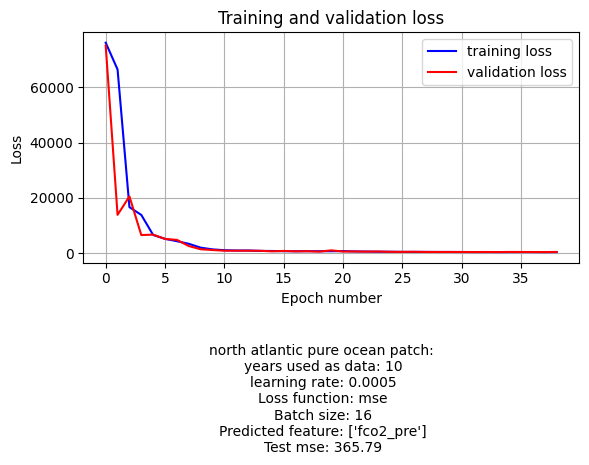

In [40]:
from datetime import datetime


plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.subplots_adjust(bottom=0.4)
plt.figtext(0.5, 0.01, f"north atlantic pure ocean patch: \nyears used as data: {amountYears}\nlearning rate: {lr}\nLoss function: {loss_function}\nBatch size: {str(batch_size)}\nPredicted feature: {feature_to_predict}\nTest mse: {test_loss:.2f}",
            wrap=True, horizontalalignment='center', fontsize=10, color='black')

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
path = '../plots/u-net/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

In [32]:
X_test[0].shape
test_pred = model.predict(X_test[:1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [33]:
test_pred.shape

(1, 120, 144, 1)

In [34]:
# Define map boundaries
lat_min, lat_max = -77, 90
lon_min, lon_max = -180, 180

# Create a grid
num_lat, num_lon = 360, 720  # Grid resolution
lat_grid = np.linspace(lat_min, lat_max, num_lat)
lon_grid = np.linspace(lon_min, lon_max, num_lon)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='c')

In [35]:
# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in test_pred.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon']))
    grid_values[lat_idx, lon_idx] = row['prediction']

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color="lightgrey")
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color="lightgrey")

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='100', vmax='400', cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('Pre-industrial CO2 Fugacity')

plt.title(f"'Pre-industrial CO2 fugacity")
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'iterrows'